# Slaughter Weight vs. Cash Price

In [1]:
import sys
sys.path.append('../')

import src
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/Users/ericostring/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/ericostring/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
slaughter_live_weight_ge_500 = pd.read_csv('../csv/slaughter_live_weight_ge_500.csv')
slaughter_live_weight_ge_500 = src.usda_clean_monthly(slaughter_live_weight_ge_500, historical=True)

<AxesSubplot:title={'center':'Live Slaughter Weight (LB)'}, xlabel='Date'>

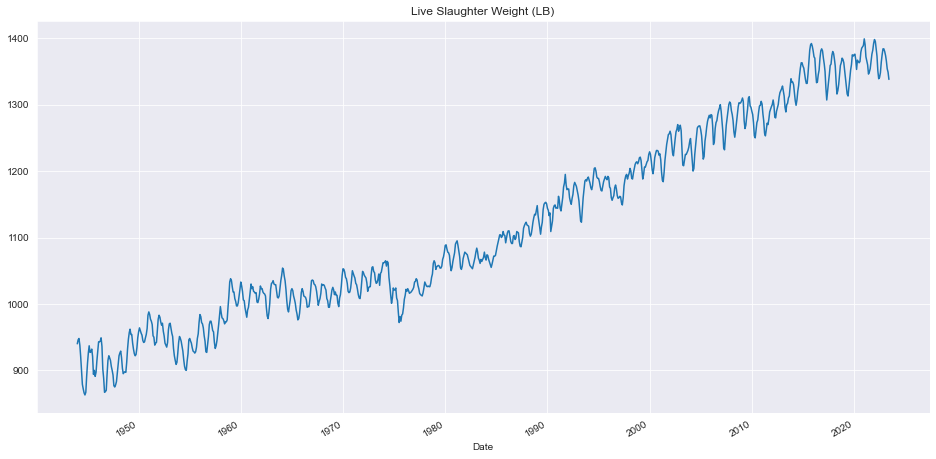

In [3]:
slaughter_live_weight_ge_500.plot(title='Live Slaughter Weight (LB)')

- Clear upward trend, nearly linear. Take percentage monthly difference to make the data more stationary, therefore more comparable across time periods

- Plotting histogram of percentage difference in slaughter weights across months

Text(0.5, 1.0, 'Monthly % change in slaughter weight (1944-2023)')

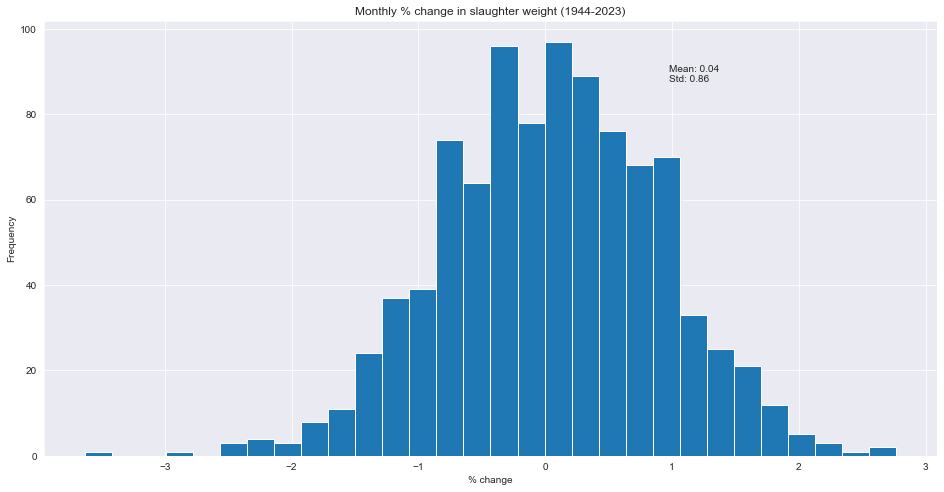

In [4]:
pct_change = slaughter_live_weight_ge_500.pct_change(1)*100

plt.hist(pct_change, bins=30)

mean = pct_change.mean()
std = pct_change.std()

plt.text(0.7, 0.9, f"Mean: {mean:.2f}\nStd: {std:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.ylabel("Frequency")
plt.xlabel("% change")
plt.title("Monthly % change in slaughter weight (1944-2023)")

- There is likely seasonality involved. If we want to know whether a given monthly percentage change in slaughter weight is an outlier, we need to compare against the same month across years

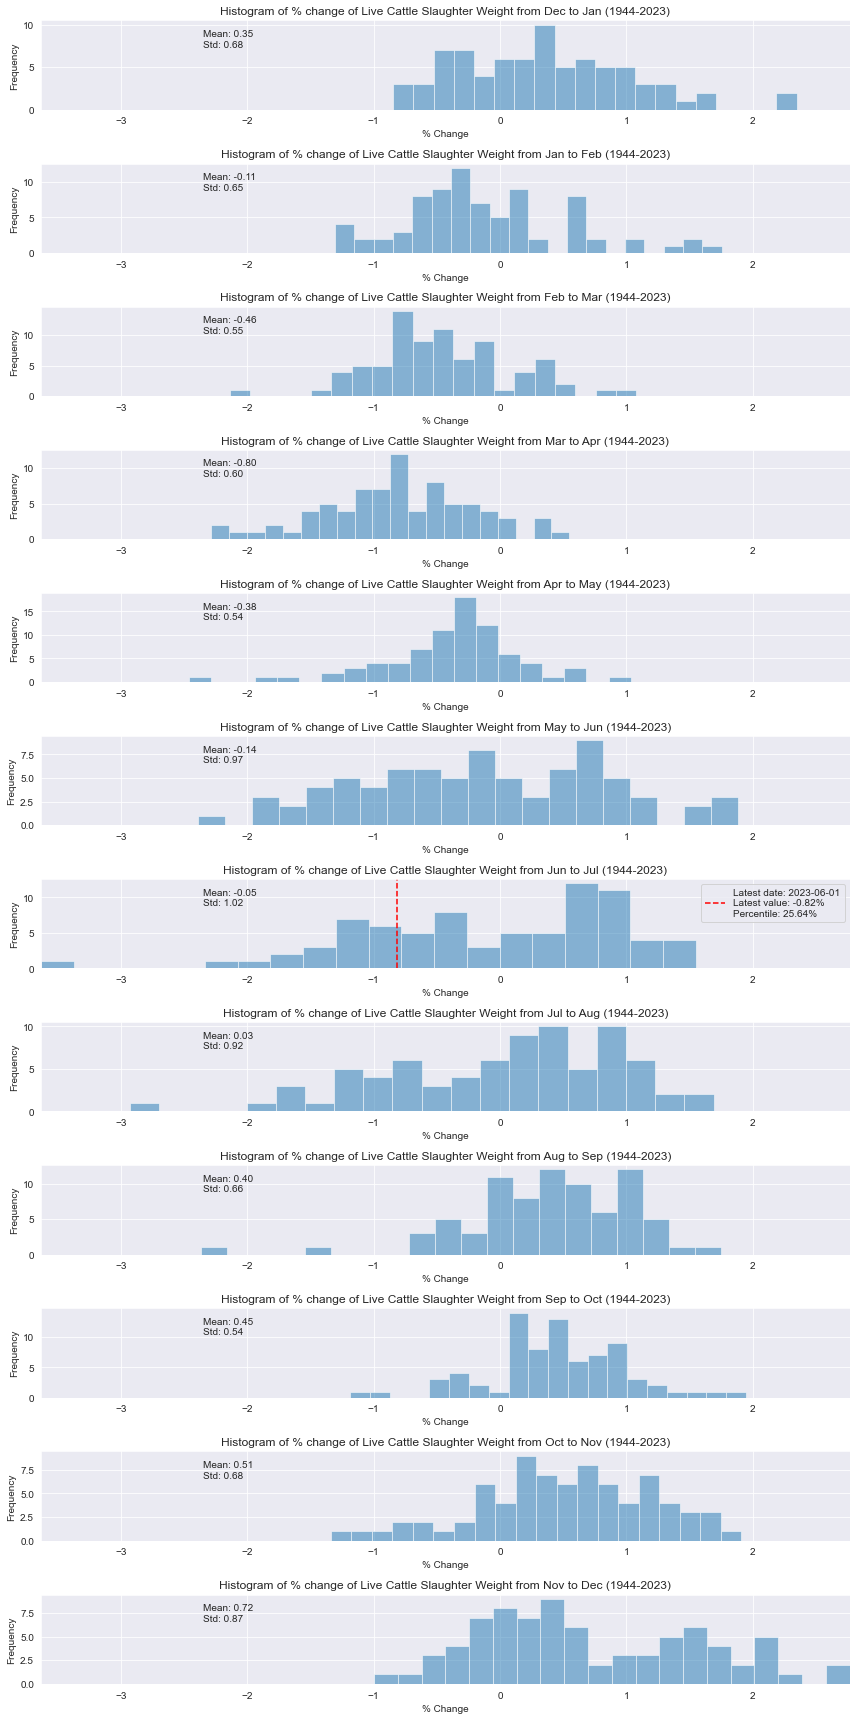

In [5]:
import matplotlib.pyplot as plt
import numpy as np

look_back = 1

pct_change_lookback = slaughter_live_weight_ge_500.pct_change(look_back)*100
pct_change_group = pct_change_lookback.groupby(pct_change_lookback.index.month)

lates_pct_change = pct_change_lookback[-1]
latest_date = pct_change_lookback.index[-1]

fig, axs = plt.subplots(nrows=12, figsize=(12, 24))

for i, (ax, pct_change_m) in enumerate(zip(axs, pct_change_group)):
    
    pct_change_m = pct_change_m[1].dropna()
    ax.hist(pct_change_m, bins=20, alpha=0.5)

    mu, std = np.mean(pct_change_m), np.std(pct_change_m)
    ax.text(0.2, 0.9, f"Mean: {mu:.2f}\nStd: {std:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_title(f'Histogram of % change of Live Cattle Slaughter Weight from {src.number_to_month[(11+i)%12]} to {src.number_to_month[i]} (1944-2023)')
    ax.set_xlabel('% Change')
    ax.set_ylabel('Frequency')

    ax.set_xlim(pct_change_lookback.min(), pct_change_lookback.max())

    if i == latest_date.month:

        percentile = (pct_change_m < lates_pct_change).sum() / len(pct_change_m) * 100
        ax.axvline(x=pct_change_lookback.iloc[-1], color='r', linestyle='--', label=f'Latest date: {latest_date.date()}\nLatest value: {round(lates_pct_change,2)}%\nPercentile: {round(percentile,2)}%')
        ax.legend()

plt.tight_layout()
plt.show()

- There is seasonality in the %∆ slaughter weight across months
    - Spring: the %∆ of live cattle slaughter weight turns from positive to negative, indicating that cattle are spending less time in the feedlot (assuming weight at entry is constant, and rate of gain is the same)
    - Summer: % ∆ remains negative, again indicating cattle are spending a shorter amount of time in the feedlot each month
    - Fall: % ∆ flips from negative to positive, therefore cattle are spending longer time in the feedlot each month
    - Winter: % ∆ remains positive

- Note how most histograms follow a normal distribution, but some months have a bimodal distribution instead

- Next, check how %∆ in slaughter weight relates to %∆ in cash price
- For each month, calculate the Z score of the %∆ in slaughter weight, with respect to other values for the same month across years

In [6]:
price_received_ge_500_national = pd.read_csv('../csv/price_received_ge_500_national.csv')
price_received_ge_500_national = src.usda_clean_monthly(price_received_ge_500_national)
adj_price_received_ge_500_national = src.adjust_series_cpi(price_received_ge_500_national) # Adjust for inflation

In [7]:
pct_change_slaughter_weight = slaughter_live_weight_ge_500.pct_change()

means = pct_change_slaughter_weight.groupby(pct_change_slaughter_weight.index.month).transform('mean')
stds = pct_change_slaughter_weight.groupby(pct_change_slaughter_weight.index.month).transform('std')

pct_change_z_score = (pct_change_slaughter_weight - means) / stds # Get z-score 

pct_change_z_score_cut = pct_change_z_score[pct_change_z_score.index >= src.Config.analysis_start_date]

In [8]:
pct_change_z_score_cut.tail(12)

Date
2022-07-01    0.197864
2022-08-01    0.533018
2022-09-01    1.181774
2022-10-01    0.651574
2022-11-01    0.212228
2022-12-01   -0.817240
2023-01-01   -0.928855
2023-02-01   -0.493439
2023-03-01   -0.223056
2023-04-01   -0.130563
2023-05-01    0.011346
2023-06-01   -0.689006
Name: Value, dtype: float64

- Since Dec 2022, the %∆ in slaughter weight between each month has been usually more negative / smaller, than compared to prior years
- Even though seasonally the slaughter weight is expected to decrease from February onwards, this years has been an outlier in terms of decreased slaughter weigth, indicating an abnormally high slaughter rate.
- The latest slaughter weigth %∆ is a mild outlier, but so are nearly all the previous 6 months (in the same direction). Taken togeather, this is an outlier. i.e. cattle slaughter has been at an unusally high rate

- Investigating how price affects slaughter weight
- Hypothesis: If there is an uptick in price between months, we expect feedlots to react by choosing to increase supply for the following months, therefore they will turnover their cattle in the feedlot faster, and slaughter weight should decrease. Expect a negative correlation between %∆ in price and %∆ in slaughter weights in the following months.

In [9]:
pct_change_z_score.shift

<bound method Series.shift of Date
1944-01-01         NaN
1944-02-01    1.140937
1944-03-01    1.213858
1944-04-01   -0.423553
1944-05-01   -2.624849
                ...   
2023-02-01   -0.493439
2023-03-01   -0.223056
2023-04-01   -0.130563
2023-05-01    0.011346
2023-06-01   -0.689006
Name: Value, Length: 946, dtype: float64>

In [10]:
def linear_regression_by_lag(y, x, max_lag=5):

    df = pd.DataFrame()

    df['y'] = y

    for lag in range(0, max_lag+1):
        df[f'x_lag_{lag}'] = x.shift(-lag)

    df = df.dropna()

    for lag in range(max_lag+1):
        X = df.loc[:, f'x_lag_{lag}']
        X = sm.add_constant(X)  # Add a constant (intercept) to the model
        model = sm.OLS(df['y'], X).fit()  # Fit the OLS model
        print(f"Lag {lag}:\t\tSlope = {model.params[1]:.4f}\t\tP-value = {model.pvalues[1]:.4f}")


In [11]:
import statsmodels.api as sm

max_lag=5

y = pct_change_z_score
df_x = pd.DataFrame()


for lag in range(0, max_lag+1):
    df_x[f'y_lag_{lag}'] = y.shift(-lag)

df_x['x'] = adj_price_received_ge_500_national.resample('MS').last().pct_change()

df_x = df_x.dropna()



for lag in range(max_lag+1):
    X = sm.add_constant(df_x.x)  # Add a constant (intercept) to the model
    model = sm.OLS(df_x[f'y_lag_{lag}'], X).fit()  # Fit the OLS model
    print(f"Lag {lag}:\t\tSlope = {model.params[1]:.4f}\t\tP-value = {model.pvalues[1]:.4f}")

Lag 0:		Slope = -6.3289		P-value = 0.0002
Lag 1:		Slope = -5.0272		P-value = 0.0028
Lag 2:		Slope = -5.4513		P-value = 0.0012
Lag 3:		Slope = -2.7122		P-value = 0.1083
Lag 4:		Slope = -0.5663		P-value = 0.7379
Lag 5:		Slope = 1.2596		P-value = 0.4560


- Lags 0-4 have negative coeffficients and most with low p-values, indicating that %∆ in price is negatively associated with %∆ in slaughter weight z-score
    - i.e. if we observe an increase in price during the current month, we expect the slaughter wait to decrease during the following months
    - possible explanation is that given the current price rise, producers react by increasing their rate of slaughter in the following months --> causing slaughter weight to decrease

No handles with labels found to put in legend.


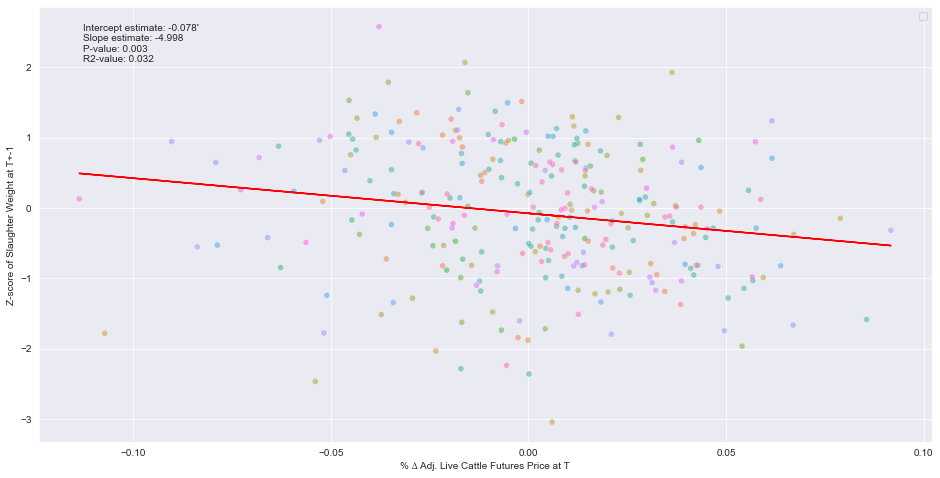

In [12]:
lag = -1

src.scatterplot(
    pct_change_z_score_cut.shift(-1),
    adj_price_received_ge_500_national.resample('MS').last().pct_change(),
    f'Z-score of Slaughter Weight at T+{lag}',
    '% ∆ Adj. Live Cattle Futures Price at T',
    resample='MS',
    reg=True,
    constant=True,
)

- Next look into how slaughter weight can affect price
- Hypothesis: a higher %∆ in slaughter weight z-score, means a slower slaughter rate than usual, therefore less supply, in turn a higher % ∆ in price.
- Don't see a reason why prices should have a lag in reaction time
- Expect the association to be positive and most significant at early lags, with less positive & significant as time passes